**ALL LIBRARY REQUIRED**

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
import numpy as np
import tensorflow as tf
from scipy.stats import sem
import joblib
import matplotlib.pyplot as plt

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

***DATA PREPROCESSING***

In [ ]:
# Load the dataset
url = 'https://p16-bot-sign-sg.ciciai.com/tos-alisg-i-b2l6bve69y-sg/0a542996a2e74931b9a17cc3fb593feb.csv~tplv-b2l6bve69y-image.image?rk3s=68e6b6b5&x-expires=1719816096&x-signature=hvoff8lKbCLE4lp7Nfk5Cir9yn4%3D'
data = pd.read_csv(url)

# Handling Missing Values
# Fill missing values with the mean of the column
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
ordinal_binary_cols = ['HighChol', 'CholCheck', 'Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'DiffWalk', 'Stroke', 'HighBP', 'Diabetes']

for col in numerical_cols:
    if col not in ordinal_binary_cols:
        data[col].fillna(data[col].mean(), inplace=True)

# Normalizing Numerical Features
scaler = StandardScaler()
for col in numerical_cols:
    if col not in ordinal_binary_cols:
        data[col] = scaler.fit_transform(data[[col]])

# Save the preprocessed dataset
data.to_csv('preprocessed_data.csv', index=False)

print('Preprocessing completed. Preprocessed data saved as preprocessed_data.csv')
print('Preprocessed data preview:')
print(data.head(), '\n')

C:\Users\jiach\AppData\Local\Temp\ipykernel_33860\1874909134.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)


Preprocessing completed. Preprocessed data saved as preprocessed_data.csv
Preprocessed data preview:
        Age       Sex  HighChol  CholCheck       BMI  Smoker  \
0 -1.607237  1.090046       0.0        1.0 -0.542176     0.0   
1  1.197681  1.090046       1.0        1.0 -0.542176     1.0   
2  1.548296  1.090046       0.0        1.0 -0.542176     0.0   
3  0.847066  1.090046       1.0        1.0 -0.261036     1.0   
4 -0.204778 -0.917392       0.0        1.0 -0.120466     1.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  HvyAlcoholConsump  \
0                   0.0           1.0     0.0      1.0                0.0   
1                   0.0           0.0     1.0      0.0                0.0   
2                   0.0           1.0     1.0      1.0                0.0   
3                   0.0           1.0     1.0      1.0                0.0   
4                   0.0           1.0     1.0      1.0                0.0   

    GenHlth  MentHlth  PhysHlth  DiffWalk  Stroke  

***SAMPLING***

In [ ]:
# Select relevant features related to eating habits and other relevant variables
features = ['Fruits', 'Veggies', 'HvyAlcoholConsump', 'Age', 'BMI', 'Smoker']
X = data[features]
y = data['Diabetes']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test.values, dtype=tf.float32)


***MODEL BUILDING*** ***(LOGITIC REGRESSION)***

In [ ]:
class LogisticRegressionModel(tf.keras.Model):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = tf.keras.layers.Dense(1, activation='sigmoid')
    
    def call(self, inputs):
        return self.linear(inputs)


***MODEL BUILDING (SVM)***

In [ ]:
class SVMModel(tf.keras.Model):
    def __init__(self, input_dim):
        super(SVMModel, self).__init__()
        self.linear = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01))
    
    def call(self, inputs):
        return self.linear(inputs)

*Initialize the models, loss functions, and optimizer*

In [ ]:
input_dim = X_train.shape[1]
binary_crossentropy = tf.keras.losses.BinaryCrossentropy()
hinge_loss = tf.keras.losses.Hinge()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

***MODEL_TRAINING*** ***(LOGITIC REGRESSION)***

In [ ]:
def train_model(model, X_train, y_train, loss_fn, epochs=100):
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            logits = model(X_train)
            loss = loss_fn(y_train, logits)
            regularization_loss = tf.reduce_sum(model.losses)
            total_loss = loss + regularization_loss
        
        gradients = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss.numpy():.4f}')


**MODEL EVALUATION**

In [ ]:
def evaluate_model(model, X_test, y_test):
    logits = model(X_test)
    predictions = tf.round(tf.sigmoid(logits)) if isinstance(model, LogisticRegressionModel) else tf.sign(logits)
    predictions = tf.squeeze(predictions)
    y_test_numpy = y_test.numpy()
    predictions_numpy = predictions.numpy() if isinstance(model, LogisticRegressionModel) else (predictions.numpy() + 1) / 2  # Convert -1/1 to 0/1
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test_numpy, predictions_numpy)
    
    # Calculate precision
    precision = precision_score(y_test_numpy, predictions_numpy)
    
    # Calculate sensitivity (recall)
    recall = recall_score(y_test_numpy, predictions_numpy)
    
    # Calculate F1 score
    f1 = f1_score(y_test_numpy, predictions_numpy)
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test_numpy, predictions_numpy).ravel()

    # Calculate ROC AUC
    probabilities = tf.sigmoid(logits).numpy()
    roc_auc = roc_auc_score(y_test_numpy, probabilities)
    
    return accuracy, precision, recall, f1, roc_auc, tn, fp, fn, tp

***100 evaluations using bootstrapping***

In [ ]:
num_evaluations = 100
logistic_metrics = []
svm_metrics = []
best_logistic_model = None
best_svm_model = None
best_logistic_score = -np.inf
best_svm_score = -np.inf

for _ in range(num_evaluations):
    # Bootstrap sampling
    X_resampled, y_resampled = resample(X_train, y_train, n_samples=len(X_train), random_state=None)
    
    # Convert resampled data to TensorFlow tensors
    X_resampled_tensor = tf.convert_to_tensor(X_resampled, dtype=tf.float32)
    y_resampled_tensor = tf.convert_to_tensor(y_resampled.values, dtype=tf.float32)
    
    # Reinitialize the models and optimizer for each iteration
    lr_model = LogisticRegressionModel(input_dim)
    svm_model = SVMModel(input_dim)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    # Train the logistic regression model
    print("Training Logistic Regression Model")
    train_model(lr_model, X_resampled_tensor, y_resampled_tensor, binary_crossentropy)
    
    # Evaluate the logistic regression model
    lr_metrics = evaluate_model(lr_model, X_test_tensor, y_test_tensor)
    logistic_metrics.append(lr_metrics)
    
    # Save the best logistic regression model
    if lr_metrics[0] > best_logistic_score:
        best_logistic_score = lr_metrics[0]
        best_logistic_model = lr_model
    
    # Train the SVM model
    print("Training SVM Model")
    train_model(svm_model, X_resampled_tensor, y_resampled_tensor, hinge_loss)
    
    # Evaluate the SVM model
    svm_metrics_evaluation = evaluate_model(svm_model, X_test_tensor, y_test_tensor)
    svm_metrics.append(svm_metrics_evaluation)
    
    # Save the best SVM model
    if svm_metrics_evaluation[0] > best_svm_score:
        best_svm_score = svm_metrics_evaluation[0]
        best_svm_model = svm_model

# Save the best models
joblib.dump(best_logistic_model, 'model/(bmi_age)_diabetes_logistic_model.pkl')
joblib.dump(best_svm_model, 'model/(bmi_age)_diabetes_svm_model.pkl')

Training Logistic Regression Model
Epoch [10/100], Loss: 0.6714
Epoch [20/100], Loss: 0.6452
Epoch [30/100], Loss: 0.6260
Epoch [40/100], Loss: 0.6132
Epoch [50/100], Loss: 0.6051
Epoch [60/100], Loss: 0.6001
Epoch [70/100], Loss: 0.5970
Epoch [80/100], Loss: 0.5949
Epoch [90/100], Loss: 0.5935
Epoch [100/100], Loss: 0.5927
Training SVM Model
Epoch [10/100], Loss: 1.0259
Epoch [20/100], Loss: 0.8732
Epoch [30/100], Loss: 0.8006
Epoch [40/100], Loss: 0.7663
Epoch [50/100], Loss: 0.7461
Epoch [60/100], Loss: 0.7355
Epoch [70/100], Loss: 0.7308
Epoch [80/100], Loss: 0.7284
Epoch [90/100], Loss: 0.7272
Epoch [100/100], Loss: 0.7267
Training Logistic Regression Model
Epoch [10/100], Loss: 0.8638
Epoch [20/100], Loss: 0.8028
Epoch [30/100], Loss: 0.7525
Epoch [40/100], Loss: 0.7133
Epoch [50/100], Loss: 0.6839
Epoch [60/100], Loss: 0.6624
Epoch [70/100], Loss: 0.6465
Epoch [80/100], Loss: 0.6346
Epoch [90/100], Loss: 0.6253
Epoch [100/100], Loss: 0.6179
Training SVM Model
Epoch [10/100], Los

['model/(bmi_age)_diabetes_svm_model.pkl']

***Confidence Interval (95%)***

In [ ]:
def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    se = sem(data)
    margin_of_error = se * 1.96  # For 95% confidence interval
    return mean, margin_of_error

# Calculate average metrics for logistic regression
logistic_metrics_array = np.array(logistic_metrics)
logistic_mean_metrics = np.mean(logistic_metrics_array, axis=0)

# Calculate average metrics for SVM
svm_metrics_array = np.array(svm_metrics)
svm_mean_metrics = np.mean(svm_metrics_array, axis=0)

logistic_cis = [calculate_confidence_interval(logistic_metrics_array[:, i]) for i in range(logistic_metrics_array.shape[1])]
svm_cis = [calculate_confidence_interval(svm_metrics_array[:, i]) for i in range(svm_metrics_array.shape[1])]

***EVALUTION RESULT***

In [ ]:
# Create a performance comparison table
metrics_names = ['Accuracy', 'Precision', 'Sensitivity (Recall)', 'F1 Score', 'ROC AUC', 'TN', 'FP', 'FN', 'TP']
comparison_df = pd.DataFrame({
    'Metric': metrics_names,
    'Logistic Regression Mean': logistic_mean_metrics,
    'Logistic Regression CI': [f'{ci[0]:.4f} ± {ci[1]:.4f}' for ci in logistic_cis],
    'SVM Mean': svm_mean_metrics,
    'SVM CI': [f'{ci[0]:.4f} ± {ci[1]:.4f}' for ci in svm_cis]
})
print(comparison_df)
#save the comparison table to a csv file
comparison_df.to_csv('performance/performance_comparison_[1].csv', index=False)

                 Metric  Logistic Regression Mean Logistic Regression CI  \
0              Accuracy                  0.498550        0.4986 ± 0.0000   
1             Precision                  0.498550        0.4986 ± 0.0000   
2  Sensitivity (Recall)                  1.000000        1.0000 ± 0.0000   
3              F1 Score                  0.665377        0.6654 ± 0.0000   
4               ROC AUC                  0.732750        0.7328 ± 0.0048   
5    True Positive (TP)                  0.000000        0.0000 ± 0.0000   
6    True Negative (TN)               7090.000000     7090.0000 ± 0.0000   
7   False Positive (FP)                  0.000000        0.0000 ± 0.0000   
8   False Negative (FN)               7049.000000     7049.0000 ± 0.0000   

      SVM Mean               SVM CI  
0     0.688844      0.6888 ± 0.0007  
1     0.668808      0.6688 ± 0.0014  
2     0.745188      0.7452 ± 0.0026  
3     0.704807      0.7048 ± 0.0007  
4     0.752392      0.7524 ± 0.0008  
5  4486.740

***Cost Benefit Analysis (CBA)***

In [ ]:
# Define the cost-benefit analysis function
def cost_benefit_analysis(tn, fp, fn, tp, cost_benefit_matrix):
    return tn * cost_benefit_matrix[0][0] + fp * cost_benefit_matrix[0][1] + fn * cost_benefit_matrix[1][0] + tp * cost_benefit_matrix[1][1]


# Define a hypothetical cost-benefit matrix
cost_benefit_matrix = np.array([[0, -1], [-5, 1]])
# Perform cost-benefit analysis for the best models
best_lr_metrics = evaluate_model(best_logistic_model, X_test_tensor, y_test_tensor)
best_svm_metrics = evaluate_model(best_svm_model, X_test_tensor, y_test_tensor)

lr_cost_benefit = cost_benefit_analysis(*best_lr_metrics[5:], cost_benefit_matrix)
svm_cost_benefit = cost_benefit_analysis(*best_svm_metrics[5:], cost_benefit_matrix)

print(f'Cost-Benefit Analysis for Logistic Regression: {lr_cost_benefit}')
print(f'Cost-Benefit Analysis for SVM: {svm_cost_benefit}')

Cost-Benefit Analysis for Logistic Regression: -41
Cost-Benefit Analysis for SVM: -6681


***ROC Plot***

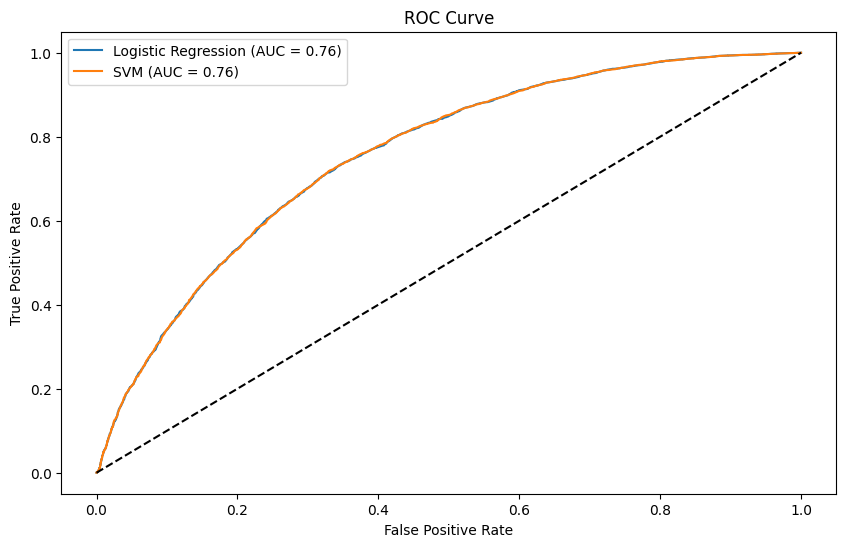

In [ ]:
logistic_probabilities = tf.sigmoid(best_logistic_model(X_test_tensor)).numpy()
svm_probabilities = tf.sigmoid(best_svm_model(X_test_tensor)).numpy()

logistic_fpr, logistic_tpr, _ = roc_curve(y_test_tensor, logistic_probabilities)
svm_fpr, svm_tpr, _ = roc_curve(y_test_tensor, svm_probabilities)

logistic_auc = auc(logistic_fpr, logistic_tpr)
svm_auc = auc(svm_fpr, svm_tpr)

plt.figure(figsize=(10, 6))
plt.plot(logistic_fpr, logistic_tpr, label=f'Logistic Regression (AUC = {logistic_auc:.2f})')
plt.plot(svm_fpr, svm_tpr, label=f'SVM (AUC = {svm_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
#end of code
#release gpu memory
from numba import cuda
cuda.select_device(0)
cuda.close()

: 